In [1]:
import matplotlib.pyplot as plt

import snowflake.connector
import joblib
import scipy

import pandas as pd 
import numpy as np

from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
from sqlalchemy.dialects import registry

from azureml.core import Workspace, Dataset, Run
from azureml.core.model import Model


from azure.identity import ManagedIdentityCredential, InteractiveBrowserCredential, DefaultAzureCredential
from azure.keyvault.secrets import SecretClient

from sentence_transformers import SentenceTransformer, util

from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE, MDS
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import cosine
import torch
from sklearn.metrics import jaccard_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scipy.spatial import distance


from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer, sample_dataset

from datasets import Dataset
import evaluate
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression

ModuleNotFoundError: No module named 'snowflake.sqlalchemy'

In [4]:
from umap import UMAP

In [5]:
pd.options.display.max_columns = None
pd.set_option('display.max_row', 2500)

In [4]:
subscription_id = '75310040-ed56-4e53-83e0-80f23ef48cd6'
resource_group = 'dlsap-PaaS-PRD-rgp-001'
workspace_name = 'Finance_DS'

workspace = Workspace(subscription_id, resource_group, workspace_name)

In [18]:
credential = DefaultAzureCredential()
secret_client = SecretClient(vault_url="https://financeds.vault.azure.net/", credential=credential)
        
account = secret_client.get_secret("snowflake-account").value
user = secret_client.get_secret("snowflake-user").value
password = secret_client.get_secret("snowflake-password").value
database = secret_client.get_secret("snowflake-database").value
role = secret_client.get_secret("snowflake-role").value
warehouse = secret_client.get_secret("snowflake-warehouse").value

engine_1 = create_engine(URL(
            account = account,
            user = user,
            password = password,
            database = database,
            role = role,
            warehouse=warehouse,
            schema='sinergi'
        ))

query_1 = f""" select * from RW_ACTUALS_ALL_TR
        """
incidents = pd.read_sql(query_1, con=engine_1)



EnvironmentCredential.get_token failed: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
incidents[incidents['case_description_en'] == 'The old emergency number was still attached to the barrier at the Garstadt power plant']

,caseno,company,functional_group,function,functional_area,functional_location,functional_sub_location,location_sid,location_short,country_short,sl_country,sl_location_lvl_1,sl_location_lvl_2,sl_location_lvl_3,sl_location_lvl_4,title,employment_category,case_type,case_severity,actual_workdays_lta,case_description,status,hazard_physical_security_event,work_process,imm_action_taken_recom,full_investigation_done,case_occurence_date,created_date,modified_date,approved_within_deadline,personal_injuries,case_closed_date,cases_no_of_registrations,valid_from,valid_to,case_description_en,language
4663,24407,Uniper Group (70006651),COO (70017898),Asset Operations (70017927),Hydro DE (70018324),Kraftwerksgruppe Main (70018329),,28056,Main,DE,Germany,Hydro DE,Rivergroup Main,None,None,Alte Notfallnummer,Uniper employee,Safety,Observations,NaN,An der Schranke beim KW Garstadt war noch die ...,Closed,Lack of emergency routes,-- Not selected --,None,Not investigated,2022-02-07,2022-03-23,2022-03-24,No,NaN,2022-03-24,1.0,2022-09-14 09:28:01,2100-12-31,The old emergency number was still attached to...,de
4899,24407,Uniper Group (70006651),COO (70017898),Asset Operations (70017927),Hydro DE (70018324),Kraftwerksgruppe Main (70018329),,28056,Main,DE,Germany,Hydro DE,Rivergroup Main,None,None,Alte Notfallnummer,Uniper employee,Environment,Observations,NaN,An der Schranke beim KW Garstadt war noch die ...,Closed,Lack of emergency routes,-- Not selected --,None,Not investigated,2022-02-07,2022-03-23,2022-03-24,No,NaN,2022-03-24,1.0,2022-09-14 09:28:01,2100-12-31,The old emergency number was still attached to...,de


In [6]:
incidents.head(3)

,caseno,company,functional_group,function,functional_area,functional_location,functional_sub_location,location_sid,location_short,country_short,sl_country,sl_location_lvl_1,sl_location_lvl_2,sl_location_lvl_3,sl_location_lvl_4,title,employment_category,case_type,case_severity,actual_workdays_lta,case_description,status,hazard_physical_security_event,work_process,imm_action_taken_recom,full_investigation_done,case_occurence_date,created_date,modified_date,approved_within_deadline,personal_injuries,case_closed_date,cases_no_of_registrations,valid_from,valid_to,case_description_en,language
0,32776,Uniper Group (70006651),COO (70017898),Asset Operations (70017927),CCGT (70017930),Grain UK (70019210),,8138,PP GRA,UK,UK,Gas Turbine Fleet,Grain,None,None,61BFT20 CB faulty,Uniper employee,Process Safety,Near Hits,NaN,415V circuit breaker from 11kv transformer sup...,Approved,Occupational Safety and Process Safety,Inspection and monitoring,Recommended to fault find why this has happene...,Investigated,2023-03-19,2023-03-20,2023-05-24,No,NaN,None,1.0,2023-05-25 01:50:46,2100-12-31,415V circuit breaker from 11kv transformer sup...,en
1,32024,Uniper Group (70006651),COO (70017898),Nuclear Sweden (70017948),PM Oskarshamn (70018698),,,8141,NPP OS,NO,Sweden,Nuclear Sweden,Oskarshamn (Nuclear),None,None,Oskarshamn 1 - RIO - Pardörr mellan 4.71 och 4...,Contractor,Safety,Observations,NaN,Oskarshamn 1 - RIO - Pardörr mellan 4.71 och 4...,Closed,Occupational Safety and Process Safety,-- Not selected --,None,Not investigated,2023-02-15,2023-02-15,2023-05-24,-- Not selected --,NaN,2023-03-17,1.0,2023-05-25 01:50:46,2100-12-31,Oskarshamn 1 - RIO - Pair door between 4.71 an...,sv
2,29905,Uniper Group (70006651),COO (70017898),Asset Operations (70017927),Hydro DE (70018324),Kraftwerksgruppe Lech (70018328),Betrieb & Instandhaltung (70018347),8279,FIS,DE,Germany,Hydro DE,Rivergroup Lech,Finsterau KW,None,Fluchtwegekennzeichnung,Uniper employee,None,Observations,NaN,Fluchtwegekennzeichnung Lagerraum Ausgangsbauw...,Closed,Lack of emergency routes,-- Not selected --,Kraftwerker eingewiesen und Anbringung angeord...,Not investigated,2022-11-21,2022-11-25,2023-05-24,No,NaN,2023-05-24,1.0,2023-05-25 01:50:46,2100-12-31,Escape route marking storage room starting str...,de


In [7]:
incidents = incidents.drop_duplicates(['caseno', 'case_type'])
incidents = incidents[~incidents['case_type'].isna()]

In [8]:
texts = incidents['case_description_en'].values
targets = incidents['case_type'].values

In [9]:
texts_train, texts_test, targets_train, targets_test = train_test_split(texts, targets, test_size=0.15)

In [10]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
Y_train = enc.fit_transform(targets_train.reshape(-1, 1))
Y_test = enc.fit_transform(targets_test.reshape(-1, 1))

## 3:

In [65]:
model = SetFitModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2',
    use_differentiable_head=True,
    head_params={'out_features': 6}, )

model_ = SentenceTransformer('all-mpnet-base-v2')

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [74]:
model_ = SentenceTransformer('all-mpnet-base-v2')

In [8]:
ord_enc = OrdinalEncoder()
ord_enc.fit(targets_train.reshape(-1, 1))

targets_test_ = ord_enc.transform(targets_test.reshape(-1, 1))
targets_train_ = ord_enc.transform(targets_train.reshape(-1, 1))

In [9]:
targets_test_ = targets_test_.flatten()
targets_train_ = targets_train_.flatten()

In [11]:
eval_dataset = Dataset.from_dict({'text':  texts_test, 'label': targets_test_})
train_dataset = Dataset.from_dict({'text':  texts_train, 'label': targets_train_})

In [69]:
def compute_metrics(y_pred, y_test):
    y_pred = list(y_pred.cpu().numpy())
    return {
        "presision": precision_score(y_test, y_pred, pos_label='positive', average='micro'),
        "recall": recall_score(y_test, y_pred, pos_label='positive', average='micro'),
    }

In [72]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    metric=compute_metrics,
    num_iterations=5,
    num_epochs=2,
    batch_size=8,
)



In [73]:
trainer.train()
metrics = trainer.evaluate()

Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 90270
  Num epochs = 2
  Total optimization steps = 22568
  Total train batch size = 8


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/11284 [00:00<?, ?it/s]

Iteration:   0%|          | 0/11284 [00:00<?, ?it/s]

***** Running evaluation *****
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [76]:
metrics

{'presision': 0.015683814303638646, 'recall': 0.015683814303638646}

In [91]:
df[df['label'] == df['label_pred']]

,text,label,label_pred
29,Blocked fire hydrant 2V0396D - Clearance,Operational loss,Operational loss
108,Significant number of failures of undervoltage...,Asset and Reputation damage/loss,Asset and Reputation damage/loss
204,The glass panes on 28m block 1 on the degasser...,Asset and Reputation damage/loss,Asset and Reputation damage/loss
255,RRM Rail Welding,Operational loss,Operational loss
310,"Defective fan, NBP not functional",Asset and Reputation damage/loss,Asset and Reputation damage/loss
410,Fan heater in the 35kV cable cellar has expire...,Asset and Reputation damage/loss,Asset and Reputation damage/loss
414,"A fire door does not close properly, another d...",Asset and Reputation damage/loss,Asset and Reputation damage/loss
460,Accumulation of illegally deposited garbage in...,Asset and Reputation damage/loss,Asset and Reputation damage/loss
508,SF6 shield needs to be revised in terms of con...,Asset and Reputation damage/loss,Asset and Reputation damage/loss
641,9 heaters do not have a valid DGUV V3 test.,Asset and Reputation damage/loss,Asset and Reputation damage/loss


In [77]:
preds = model.predict(texts_test)

In [83]:
preds_back = ord_enc.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).flatten()

In [84]:
df = pd.DataFrame({'text': texts_test, 'label': targets_test, 'label_pred': preds_back})

In [88]:
df_ = df[(df['label'] != 'Environment') & (df['label_pred'] == 'Environment')]

In [ ]:
df_

In [89]:
for t in df_['text']:
    display(t)

'Preservation of fuel analyses\nFound that the proportion of volatiles in 4 out of 5 samples was above the limit value of the specification. (4th/15th/20th/24.042023, see attached test report.)\nCoal has already been used in some cases.'

'Oskarshamn 3 - RA3-23 ERF - 421 valves do not have a hood/plastic.'

'Oskarshamn 3 - New lock at gates 1304 and 1305'

'Whilst attempting to fill a water bowser, the vessel has come under vacuum and damaged the vessel.'

"During dismounting from Afgraver A, the rails/biels of Opwerper are mounted.\nFastening not visible due to growth of weeds.\nI didn't want to step straight down, because then you step into a layer of mud. So I stepped a little further away from the stairs into the grass strip next to the rails (side of the stairs excavator), but in that grass (not visible) there was a bolt of the rail attachment to the rail foundation."

'Flames on the connecting cables at a contactor in the control cabinet of the steam turbine transformer block 5.'

'A construction fence is still standing in the area around the reactors, which has already been cordoned off.'

In [75]:
#model._save_pretrained('./model/')

In [6]:
model = SetFitModel._from_pretrained('./model/')
texts_train, texts_test, targets_train, targets_test = joblib.load('data.pkl')

In [92]:
embeddings_raw = model_.encode(texts_test, convert_to_tensor=False)
embeddings_finetuned = model.model_body.encode(texts_test, convert_to_tensor=False)

In [93]:
embeddings_raw_2d = UMAP(n_neighbors=32, n_components=2, 
                         min_dist=0.0, metric='cosine').fit_transform(embeddings_raw)

embeddings_finetuned_2d = UMAP(n_neighbors=32, n_components=2, 
                               min_dist=0.0, metric='cosine').fit_transform(embeddings_finetuned)

Operational loss


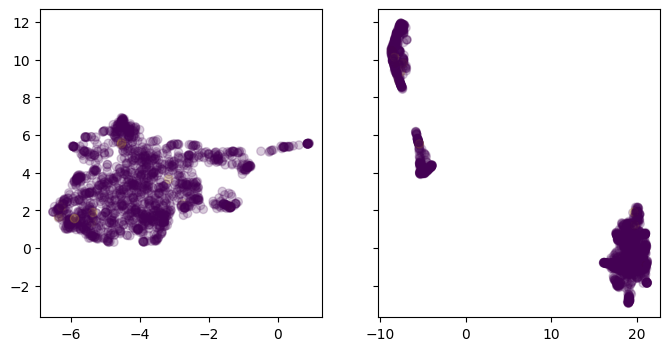

Information Security


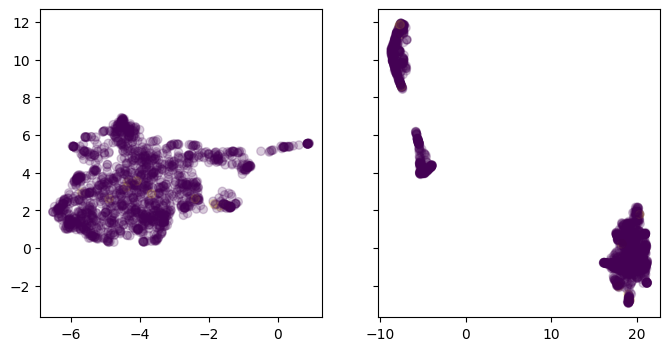

Safety


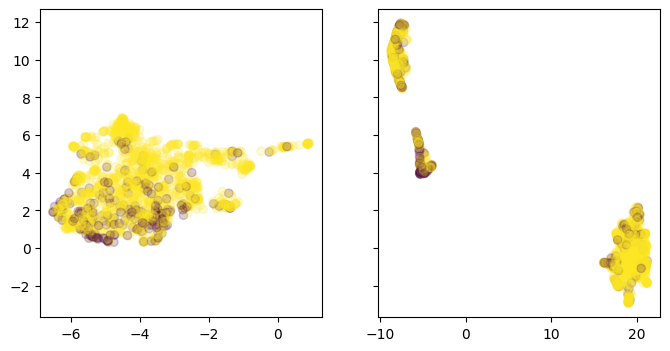

Asset and Reputation damage/loss


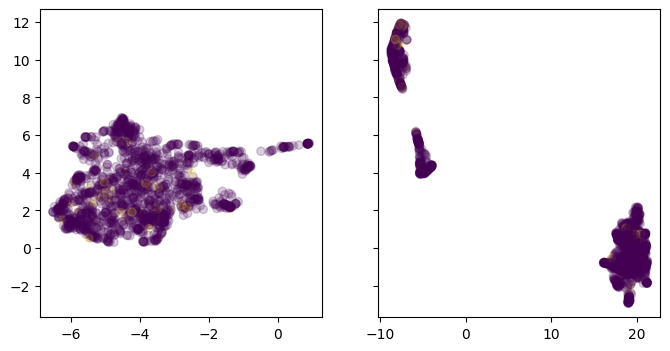

Process Safety


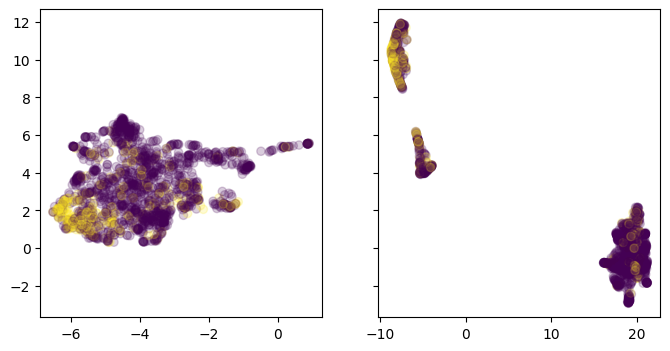

Environment


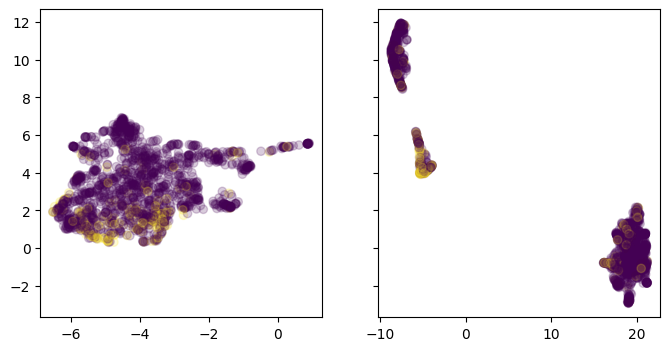

In [95]:
targets_set = set(targets_test)
for target in targets_set:
    has_label = [True if target in x else False for x in targets_test]
    fig, axs = plt.subplots(1,2, figsize=(8, 4), sharey='row')
    ax1,ax2 = axs
    print(target)
    ax1.scatter(embeddings_raw_2d[:,0], embeddings_raw_2d[:,1], c=has_label, alpha=0.2)
    ax2.scatter(embeddings_finetuned_2d[:,0], embeddings_finetuned_2d[:,1], c=has_label, alpha=0.2)
    plt.show()

### logistic regression

#### finetuned inputs

In [7]:
X_train = model.model_body.encode(texts_train, convert_to_tensor=False)
X_test = model.model_body.encode(texts_test, convert_to_tensor=False)

In [10]:
clf = LogisticRegression(max_iter=1000).fit(X_train, targets_train_)

In [11]:
labels_pred = clf.predict(X_test)

In [12]:
def compute_metrics(y_pred, y_test):
    return {
        "presision": precision_score(y_test, y_pred, average='micro'),
        "recall": recall_score(y_test, y_pred, average='micro'),
    }

In [46]:
compute_metrics(labels_pred, targets_test_)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


{'presision': 0.7208281053952321, 'recall': 0.7208281053952321}

In [47]:
preds_back = ord_enc.inverse_transform(labels_pred.reshape(-1, 1)).flatten()

In [48]:
df = pd.DataFrame({'text': texts_test, 'label': targets_test, 'label_pred': preds_back})

In [49]:
df_ = df[(df['label'] != 'Environment') & (df['label_pred'] == 'Environment')]

In [50]:
for t in df_['text']:
    display(t)

'During vacuuming work with the stationary vacuum cleaning system on 31m boiler house, a static discharge occurred via the user.'

'Whilst lorries were being filled with dust there were excessive levels escaping from the dust silo'

'The container for processing the "coals" for the GT stands around in the corner'

'WP12/5 water on floor'

'In the boiler house at 7m you will find the legacies of fitters who have not heard of leaving your construction site clean. E-waste in the area of the FW main gate valves and scrap metal in the area of the boiler floor combustion chamber hatch'

'Excessive dust on surfaces.'

'Fire load active workshop'

'Garbage/garbage/plastic are located at 0m instead of in appropriate waste containers.'

'- A filling line should be inserted from the 14m platform downwards into the container \n  of the sludge thickener. As a result, the contents of the container can be \n  can be emptied from the wagon without further transport.'

'Inspection: Environmental protection; On the Sorflash tank, the leakage indicator is not filled and also not visible. is tested by I/MT (Lackner). until?'

'Hazardous materials room: order and cleanliness ->hoses, cleaning rags, small (iron) material, canisters, etc. dispose'

'U3 FGD tripped due to cascade trip of Regen Heater caused by loss of speed sensor'

'A lot of scrap and bad order and tidiness in the scrapping workshop'

'Garbage and scrap metal were dumped at the place next to the car.'

'Trashy inside door of G0302'

'Sink without filter at KRA B1 Turbine, with activated sludge in the sink filter that was next to the sink. \nWP4.1'

'WP3 Oljespill'

'Seal oil pump No1 tripped on electrical overload. Seal oil pump No2 started but unnoticed so did the DC pump. The generator protection system discharged the hydrogen once the DC pump had run for 30 minutes. There was Hydrogen available to top up the generator on site but a there would be a potential risk if it happened again in commissioning.'

'WP3 Golvbrunn'

'Open fire doors Reception centre hotel'

'Sudden increase in the district heating storage tank up to > tank. \r\noverflowed. As a result, the Datteln 4 block would almost be off the grid with \r\nFire gone out. The reason for this is the flow control in the condensate system \r\nDue to the structural lack of check valves, it is too \r\nCross currents came. The shut-off valve 40NAB35AA101 is available in  \r\nThe lineup has gone into trouble. Two fuses are \r\nplease. At the same time, however, the valve 40NAB30AA101 opened and this \r\nCondition caused the cross flow.The main condensate is backwards in \r\nthe district heating storage tank and overfilled it. Thereby \r\nFeed water tank level dropped quickly. However, the cause was \r\ndetected in time and the error could be eliminated \r\nbecome'

'High chlorides identified in gypsum import and export samples during routine samples.'

'KH 20m south side coaling exit\nDispose of the fixed pulley of a pulley or store it if necessary'

'WP3 gas cylinders in the wrong place. T1403/T0308'

'WP3 Golvbrunn'

"Empty beer can found on BKAB's grounds"

'Marty has announced that he wants to take these temperature measurements tomorrow, depending on the ability to deposit all the steam produced. Measurements are necessary to substantiate complete waste incineration with sufficiently high temperature and residence time (Wabo permit requirement).\nDCMR Control Room requests to unsubscribe afterwards, or to let us know if necessary.\nEvent number 598950'

'Oskarshamn 3 - Radioactive waste with high radiation level in blue classified public area'

"BKAB's decision-making towards projects"

'Accumulation of illegally deposited garbage in the driveway.'

'Lack of labeling of the HSR collection bins'

'Flammable hazardous substances A.C.S 3 (= highly effective quick cleaning spray) stored slightly hidden - > never store flammable or flammable hazardous substances in areas with (coal) dust'

'Walkdown of cooling towers upon demobilization of cooling tower maintenance team revealed empty bottles, cans and cigarette ends within dry section of cooling tower.'

'WP4 can of oil on the sweep'

'Leftover water/spills on the floor within WP 12 work area'

'The evaluation of the sampling of the FGD wastewater on 26 July 2022 showed a COD value of 111 mg/l (Vorlas Main 15 mg/l) and thus exceeded the approved limit value.'

'Overflowing boxes in the soup'

'asdfasdf'

"Very small amounts got into the tank, no one was inside at the time. (PTW was released for it)\nWe carried out welding repair work in a tank. During a rest period, they told me that they could hear the water trickling inside from outside and that they wouldn't go back. I don't know exactly which stump the medium came from, but it wasn't a large amount, the tank drain was open, so it couldn't accumulate. Work stopped until the cause was found (moving motor trains)."

'Safe ID: 112201\nOskarshamn 3 - Unclear roles in the disposal of active scrap'

'There is a green sticker on the cabinet door that indicates UVV. There were no UVV in the closet.'

'The hazardous substance marking on the door to the Neutra container has been weathered'

'Oil and water was found on floor area around Main feed water pump. There was no obvious course of oil spillage. area made safe and cleaned.'

'The outdoor lecture room and AV needs to be tidied up.'

'IBC-behållare felmärkt'

'Dhnehnetn'

'Clearing away hoses lying around from test operation'

'Loss of environmental reporting data for an hour due to isolation of power supplies to spare analyser (An hour lost across the units but not lost the days reporting). Isolating the spare gas CEM analyser to connect the the new spare SICK dust analyser. Isolating the spare analyser resulted in temporary data loss to CDAS on all units (reporting system).'

'Non-category-labelled detergent can'

'Cleaning areas of plaster tapes'

'Control console of the mill disposal delivered by oil drums.'

'When a truck was unloaded, the storage tank was overfilled and heavy fuel oil leaked. The heavy fuel oil ran into the existing collection room and there was no damage to the environment.'

'During the commissioning work of the ME 2 in Breitbrunn, an oil leak was detected on the piping in the package during the inspection during the start-up process. As a result, the start process was aborted manually by the quick stop of the turbine. The oil spill was only in the package, so there was no danger to the employees and the environment at any time.'

'Inspection: Environmental protection; The test date on the ignition gas tank is not visible. The container is a rental container and we are independently inspected by the owner. Feedback from I/P'

'Personnel Gas detector went into alarm when in the IGA building due to a leak between a 1" valve and its 1/4 " fitting.'

'ABB contractor Darren Berry advised that valves which isolate pure H2 stream to purity analyser be controlled. Human factors. If the valve was left or accidentally left open, the DCS would show a 100% H2 content regardless of purity. It is common practice to have these valves locked off as is the case at other installations the contractor has visited.'

'Exterior heating oil tank: Process instruction "Behavior during truck shipments was only valid until 21.12.2018'

'Dosing station ground floor\nStorage of hazardous substance containers without water protection pallets, here NALMET 1691 and AMERSEP MP2.'

'WP12 Filterbrand'

'On 24.05.2021, the daily average value NOx was exceeded at HiDe 5.\nValue: 109.95mg/Nm³\n\nReason: Failure of NH4oh dosage'

'Inspection: NH 3 Warehouse In the compressor room there is a canister of oil on the workbench which is disposed of. until 26.08. by VE'

'At 5m at the generator discharge block 1, there is a gas cylinder with sulfur hexafluoride SF6. Please dispose of them properly.'

'Safe ID: 112139\nOskarshamn 3 - Investigation of RO-0-2022/023 Work that could have caused the release of radioactive substances carried out in passive mode in BFA'

'Oil leak from removed ACC gearbox onto hardstanding'

'Cavity in asphalt'

'Risk less: Oil has leaked from a pressure gauge in KH 2. This has been eliminated. by P/TD'

'Risk less: At 15m in the MH, hazardous substances were not stored properly. have been cleaned up by GE GE has instructed its employees again.'

'Bring the fire hose lying around to the warehouse.'

'Safety valve in gas pressure reduction has responded and relaxed natural gas into the open air via lambda blowers.'

'Stop / maintenance MPP3 incident number 776310'

'On 11.07.2023 at 3:43 a.m., an uncontrolled leakage of bearing oil occurred at the generator storage unit 2. \nThe warehouse was opened as part of maintenance measures on 10.07.2023 at approx. 13:00, the upper bearing shell was lifted off.   This state of dismantling was left at the end of the working day in order to continue the work the following day. \nWhen the automatic oil heating system went into operation during the night, the oil was able to escape from the generator bearing. This was not activated as part of the maintenance work.\nIn the bearing oil tank, approx. 47mm height was missing. This corresponds to a quantity of 1142 liters which has leaked. The leaked oil was distributed below the generator in the nacelle at 14m, 8m to -4m. \nThe leak was detected and stopped on 11.07.2023 at 04:24 during a tour.'

'Flexible hose connection to oil line with "open end", clarify frequency of use and risk of unintentional oil release (oil pump house)'

'In the course of emptying and cleaning the CCS plant, washing liquid containing NaOH had to be transported to the industrial wastewater treatment (BAA). A vacuum truck from Buchen was used for this purpose. The vacuum truck was previously used in the area of the HER tank (HER = heating oil substitute fuel). Obviously, there were still traces of HER in the vacuum truck (about 0.5 l), but this was only noticed after draining into the sump of the BAA (smell and oil eyes on the surface of the water in the BAA). No water contaminated with oil has been released into the environment. The BAA is only emptied into the jade after the water quality has been checked.'

'Missing binder with safety data sheets on oil storage'

'At 12:40 p.m., smoke developed in the 110kV single-phase substation WKW. The smoke came out of a floor shaft between circuit breaker cells and the office building. \n\nThe flap to the floor shaft was opened carefully and at a distance by the operating personnel. The smoke was dense and could not be estimated by the operating personnel, so that the FFW had to be notified. The internal reporting chain was also initiated.  \nWhen the rescue workers arrived after a short time, they were informed and instructed by the operating staff. Subsequently, the fire brigade climbed into the floor shaft with breathing apparatus and brought an oil radiator outside through a window. He had lost oil and smoked heavily. The cause of the fire was identified as a technical defect in the oil radiator. The RCD on site has tripped and turned off the circuit of the oil radiator. As a result, presumably, major damage could be avoided.\n\nEmergency doctors and the police were also on site. However, no people we

'Risk less: Due to a fault in the bottle overflow, the discharger line was severely damaged. The investigation is guided by the production department.'

'Malfunction and leakage at auxiliary valve "turbine - spiral case aeration" of rehabilitated WALDECK 2 Unit 6'

'On call engineer received a call from CDC Operations that the Cottam PRS ESD system had activated and closed all the site ESD valves and shutdown the Boiler House'

'The support for the framework of the tarpaulin was "undermined" due to the weather or the undermining threatened to extend to the support level.'

'The oil absorbent must be removed.'

'Leak observed from P 003 suction strainer STR-1-003, furnace and pump stopped immediately , suction and discharge valves isolated.'

'Stationary fire protection gas turbine / generator\n\nincluding oil systems and equipment, oil tanks, etc.\nThe gas turbine and the gas and oil skids next to the turbine are not equipped with fire-fighting systems.\n\nLack of fire protection measures on the gas turbine\n\nIt should be borne in mind that the plant does not operate frequently, or rather, only during peak load in winter, when the burner areas are supervised by employees of the plant. The open design of the gas turbine components and the lack of extinguishing water supply at this location do not allow immediate and easy installation of fire extinguishing systems.\n\nHowever, the site should consider installing a structural separation between the oil skids and the gas skids, all of which are cut-and-cover and located in close proximity. Fire separation can be carried out, for example, by fire-resistant panels.'

'Buckets of powder'

'During a tour, it was found that there is a lot of coal dust in the area of burner 3.1 Block C.  Upon closer inspection, a slight leak was found in a flange connection of the coal dust line and plug-in washer fitting.'

'Oskarshamn 3 - Short stop No. 2-22 - Noise from overhead crane in Reaktorhallen'

'WP3 Water blasting garbage bags'

'Inspection: The M-Werkstatt would like to switch to a new cooling lubricant for procurement reasons. For this purpose, tests are carried out and the technical instruction F 007 must be adapted by the hazardous substances officer. until 1.05.22'

'Risk less: heavy fuel oil station; Several leaking flanges were detected. An error message has been created. by P/TD'

'Unlabelled bottles with chemicals'

'Head side coaling on the containers at FWK: various blue barrels with wet carbon elements (probably from the storm and rain day in the 25.KW – 22.06.2023)\nPOSITIVE:\n- The barrier cats and warning signs are present on almost all lances\n- Working platform tested at level 34.0 m\n- Working platform (upper burner level) tested at level 20.0 m'

'Inspection: MH 3; Oil room, there are some dirty mats and rags in the oil room. These were disposed of. by P'

'Fluorescent lamps are placed in a corner.'

'Disposing of old cloth bags in the basement'

'Cylinder handling incorrect WP3/4/12'

'Safe ID: 108786\nOskarshamn 3 - Reconditioning of intermediate level waste'

'In the course of maintenance measures (integration of a plug-in disc) on the old connecting line of the Slopöl-Tank Pumpenhaus to the Heizöl-S Tank Alt, there was an uncontrolled release of approx. 50 litres of heating oil-S. The release occurred inside the oil pump house.\n\nExpiration:\n\nIn the course of the work permit procedure, an activation was created and provided by the shift staff. This disconnection prevents/prevented unintentional start-up of the slopol pump during work on the open piping system.\n\nIn preparation for the opening of the pipeline system, the affected pipeline had to be completely emptied. This was done via a hose connection with ball valve shut-off on the discharge side of the slopöl pump.\nThe extracted oil was fed via buckets to the leakage oil tank, the drain of which is connected to the slopoil tank.\n\nThe integration of the plug-in disc into the existing piping system was successfully carried out.\n\nIn the afternoon of 28.09.2022 at around 3:30 p.m.,

'Inside level 0.0m-close to intermediate tank 4:\nFilter Test period quality control exceeded (in 01-2005)'

#### standard inputs

In [32]:
model_ = SentenceTransformer('all-mpnet-base-v2')
X_train = model_.encode(texts_train, convert_to_tensor=False)
X_test = model_.encode(texts_test, convert_to_tensor=False)

In [33]:
clf = LogisticRegression(max_iter=1000).fit(X_train, targets_train_)

In [34]:
labels_pred = clf.predict(X_test)

In [13]:
compute_metrics(labels_pred, targets_test_)

{'presision': 0.7208281053952321, 'recall': 0.7208281053952321}

In [14]:
preds_back = ord_enc.inverse_transform(labels_pred.reshape(-1, 1)).flatten()

In [15]:
df = pd.DataFrame({'text': texts_test, 'label': targets_test, 'label_pred': preds_back})

In [16]:
df__ = df[(df['label'] == 'Environment') & (df['label_pred'] != 'Environment')]

In [17]:
for t in df__['text']:
    display(t)

'Boiler 7 level 0.0 m (basement): garbage under the stairs (exit from level 2.0 m)'

'Cleaning requirements in the FGD 0 m and WA area:\n\nIncreased need for cleaning, especially accumulation of various spare parts (presumably due to both Q shutdowns)'

'WP1 Improper storage of chemical'

'WP3 Inlet and Outlet Bouncer'

'WP3 Oil'

'Area at the old cooling towers:\nThere are various old pipelines + scaffolding materials + wooden planks lying around.\nOrigin + purpose is unclear.'

'The basic cleaning was ordered by an SAP message.'

'Oskarshamn 2 - TIL - Plasma cutting on system 315, smoke sucked into RI'

'Fly tipped building rubble dumped down Leicester Rd i.e. access road.'

'The old emergency number was still attached to the barrier at the Garstadt power plant'

'Decommissioned by trip on desk.\nKetel continues to operate for the first time. \nThis notification does not need to be terminated'

'Red plastic barriers were being transported when rubber "feet" fell off, the forklift drove over them, driver stopped and checked load then proceeded, leaving discarded and damaged feet, these were cleared by a project ERSHE.'

'During the strong winds of 8 January 2019 on the Maasvlakte, a lot of coal dust was blown from fields A1, A2, B1, B2, C1 and C2. As a result, there is strong pollution of surrounding plant parts (UCML), roads, cars and buildings.'

'Inspection: In boiler house 3 there is a puddle of sulfuric acid at 0m and a tub without marking. Area was cleaned, the area cordoned off and the tub marked. by P/ Beetle'

'KVT G13: Fuel leakage when cutting pipes.'

'The road surface around the seaweed skip is pitted and damaged to the extent that the fork lift truck wheels are getting stuck in the ruts and holes while attempting to empty the skip. At present, the access is restricted due to the works in the area.'

'Testing of various cables expired\nTesting of fire extinguishers shortly before expiry'

'WP3 Bucket of oil'

'Improper storage of paint'

'Incorrectly handled waste for clearance'

'In addition to the heavy leak tank in the catacombs of unit 2, a quantity of heavy oil has ended up.'

'WP5 Prevent leakage to ww'

'WP12 Deviation from routine: Liquid waste poured into floor drain'

'Loss of 5000L of oil into condenser pit. No release to environment.\nSee attached golden hour from shift TL.'

'On Tuesday, 12.5.20 around 2:30 p.m., Ludwig discovered during work near the piping of machine 2/3 that oil was running down from a pipe penetration on the retaining wall. They immediately informed the UST staff that the leak had been investigated and that they were able to quickly determine that a gate valve fitting was open (should not be) when the ME 2 was filling up the oil and closed it immediately. The pipeline after the fitting led to the intermediate oil tank of the ME 1,2,3, which was separated by the dismantling of the ME 3 and thus the oil could escape about 50 - 70 liters and run down via the smell in the retaining wall.'

'During plant checks on CW System a leak was identifed on the Sodium Hypochlorite Dosing Pipework and area was barriered off. On returning to the area the pipework was found to be sheared. The Sodium Hypochlorite system was immediately taken out of service and isolated in preparation for repairs.'

'Exterior façade: in several places, especially in the lower end area, the façade parts made of Eternit (Attention: asbestos contamination possible!!) have broken off, in some cases there is insulation'

'WP4 Oil in cooling room'

'WP5 Water leak'

'Risk less: MH 3, 15m; An acetone can was stored unattended on a power distributor. A briefing was carried out by GE and cleaned up.'

'Short term technical breach of instantaneous permit limit for total oxidant as chlorine, resulting in zero environmental harm.'

'A report of low oil level steering oil tank STT came in at 07:30.\nAs a result, the steering oil pumps failed, and the torn also stopped.\nOil was refilled immediately by the guard, causing the pumps and torn to start working again.\nAfter this, an investigation was carried out into a possible leak.\nLeakage found at the actuator of the A3 control valve.'

'Loss of NH3 plant due to ‘A’ side line of sight detector going active (suspect faulted lots during the day), deluge operated, key switch override applied to detector CQ107 in order to get plant back in service, subsequent load drop from 20:09hrs to 20:45hrs, plant back in service approx. 20:30hrs.'

'Risk less: MH 3, 10m, In the switchgear, an acetone bottle was placed in a control cabinet. A briefing was conducted. By GE'

'On the site Crangerstrasse 40/42 (wolf menu) we found animal waste/carcasses near our shaft. The terrain cannot be walked on in this way. A planned fire rescue drill was canceled. The Herne fire brigade has notified the veterinary office. Since the site does not belong to us, we will wait for the reaction of the authorities. With the fire brigade, another training ground is found.'

'Due to work on the gt2 operating system, the generator lubricating oil pump(s) spontaneously started running.\nAs a result, a socket in the pipe to the bearings of the generator is torn.'

'Beacon and garbage behind the dressing room must be cleared away.'

'Open fire door P0612 (Auditorium)'

'Pump of dust measurement is defective and new one will be installed this WK. There is no co-firing on this boiler.'

'Tanks in room G0301 marked with old hazard pictograms'

'During the movement of the wet bagger, a hydraulic hose installed in the hydraulic system failed. Hydraulic oil leaked locally.'

'Dust seen blowing out from Dust Silo building (specifically north vehicle bay) on eastern entry point.'

'During the recovery of flotsam with the loading crane at the RRM in the Finsing power plant by hand control, an oil leak was discovered on a pipeline.\nThe work was immediately stopped. Only some oil had leaked. No oil got into the water.'

'Food stolen from the lower dining room'

'Outdoor area material container 2: \n• Order and cleanliness\n• Do not store liquid hazardous substances in drip trays\n• Dispose of empty containers and garbage\n• Dispose of the two blue barrels and the metal plate behind the container\n• Behind the container, the pest controller has laid out a poison box, stickers are attached without a date of interpretation'

'Oskarshamn 3 - The gutters in J1.02 are neglected and when needed overhaul and cleaning'

'Manhole cover and grate'

'Risk less: MH3, 15m A bucket of tools and chemicals was found unattended, a briefing was carried out and cleaned up.'

'Centre Desk ovation reporting tool showed a different level of SO2 for 24/hr period than U1 air monitoring ovation page.'

'Inspection: There is water in the transformer furnace at the S-Oil station. the transformer is controlled by the external rotor. Instruction P,'

'Risk less: in MH 3; 15m, fluorescent tubes were disposed of with the residual waste. A briefing was carried out and the lamps were disposed of properly.'

'Blue barn.  Rescue cart environment needs to be reviewed ,possibly supplemented. Poorly inflated tires, etc.'

'Level 47.2 m east side (observation Zaubzer): loose insulating wool'

'Inspection: In the Kalk silo, a knife gate valve is leaking to the outside. An error message has been created. by I/AV'

'Risk less: after the repair of the HK there was light oil in the drip pan under the burner. This was disposed of. by P/TD'

'Sopp, brushes have probably been washed in the sink'

'Risk less: In front of the boiler house there were several wooden wedges soiled with oil. were disposed of by P/TD.'

'WP3 Unlabelled chemicals'

'Attachment coupling of hose shot.'

'In preparation for work on the weirs of the Bergheim power plant, the headwaters were lowered in order to be able to install scaffolding. this has led to the drying out of a biotope that is fed from the headwater.'

'WP3 Oil in unsuitable vessels'

'WP3 Suspected asbestos incorrectly sorted'

'- Fire extinguisher seal of approval expired\n- Pre-installation tent between the boilers \nUse by partner company, employees stood directly in wires and cables, next to cardboard boxes and actuators everything in the immediate vicinity, garbage and garbage boxes\n- In the area of all plant components garbage accumulations, pallets and boxes\n- Feed water pump room\nCables/wires, old insulation, old plant components, etc.'

'Various big packs and woods were found in the cooling tower area.'

'Basement: in the area of the mill there is 1 slop oil tank loose insulating wool, about 2 bags'

'Diesel cans inside the fishing shed (marina)'

'New control room (container):\nRemnant package of façade elements still on welded-in pallet'

'ÖVT-GT G24 vatteninsprutningstripp'

"On 14.6.2022, a trial operation of Unit 3 was carried out from 4:00 a.m. From 4 o'clock the first burners were ignited with (fuel oil extra light) HEL. The mains connection took place shortly after 6 o'clock. \nThe entire HEL route from tank 4 to the boiler house was monitored by the shift with regular patrols. The last inspection was completed by about 8:15 a.m. Until then, no abnormalities/leaks had been detected. At around 8:25 a.m., an employee noticed HEL falling to zero meters in boiler house 3. He immediately informed the control room. An intensive search for the cause/leakage was carried out immediately. At the same time, the oil slick was stopped with oil binder. \nThe oil leaked from a leaking three-way valve on the 5.1 burner. The burner was immediately taken out of service, thus stopping the oil supply."

'Both Dust Silo Doors Below No. 4 Mixer mixer were left open with a large pile of dust left on the floor.\nDust was blowing off the dust pile and travelling around site.'

'Upper level: various objects, concrete and masonry remnants, wooden boxes with garbage, pipes'

'Oskarshamn 3 - RA3-23 ERF - At the door out of the reactor hall there are several different signs that say different things. It is not entirely clear that individuals coming out of the reactor hall should scan the monitor before proceeding.'

'WP12 Bucket of liquid'

'Ascent IN 13: DENOX 4 ; The drip pans at the sewer burners were dirty. were cleaned by P/S'

'During off loading of one of the 25 litre drums at Gate  3 area, one of the drum securing caps came off causing a small amount of Hypo to spill onto floor. None of the contents came into contact with the off loading team'

'Less embers fire in led strip WP3 / water blasting'

'Clearance box overpacked with tube'

'When the annual report for 2021 was prepared, it was found that the maximum approved amount of heat for the discharge of the cooling water exceeded 270 MW, as this is not monitored by the control system.'

'Oskarshamn 0 - Lots of chemicals'

'The overall condition of the KH, MH and block coaling plant areas corresponds to a plant that has been shut down for many years.\n\nCertainly, one would wish for an extensive cleaning in some places. However, the degree of contamination does not pose an increased risk of accidents.'

'Oskarshamn 1 - RIO - Contaminated garbage containers in K4.50 on the waste'

'Baustellensauberkeit'

'Storage is missing.'

'Several (strongly) outdated versions of the Business Emergency Plan were found in the Stevenshof boiler house in Leiden (one from 2013 and one even older). This includes emergency telephone lists that list employees who have not been employed by the company for years. A current version of the Business Emergency Plan not found at the location.'

'Oskarshamn 0 - Batteries set up without bunding and weather protection'

'Measures / to be clarified\n• The containers for oily waste do not close completely: fire hazard'

'WP3 Vattenblästring'

## ----------------------

In [52]:
a = set(df_['text']) - set(df__['text'])
b = set(df__['text']) - set(df_['text'])

In [59]:
print(len(a))
print(len(b))
print(len(set(df_['text']) & set(df__['text'])))

69
18
27


In [55]:
for a_ in a:
    display(a_)

'On 11.07.2023 at 3:43 a.m., an uncontrolled leakage of bearing oil occurred at the generator storage unit 2. \nThe warehouse was opened as part of maintenance measures on 10.07.2023 at approx. 13:00, the upper bearing shell was lifted off.   This state of dismantling was left at the end of the working day in order to continue the work the following day. \nWhen the automatic oil heating system went into operation during the night, the oil was able to escape from the generator bearing. This was not activated as part of the maintenance work.\nIn the bearing oil tank, approx. 47mm height was missing. This corresponds to a quantity of 1142 liters which has leaked. The leaked oil was distributed below the generator in the nacelle at 14m, 8m to -4m. \nThe leak was detected and stopped on 11.07.2023 at 04:24 during a tour.'

'Flexible hose connection to oil line with "open end", clarify frequency of use and risk of unintentional oil release (oil pump house)'

'During vacuuming work with the stationary vacuum cleaning system on 31m boiler house, a static discharge occurred via the user.'

'Inspection: MH 3; Oil room, there are some dirty mats and rags in the oil room. These were disposed of. by P'

'Excessive dust on surfaces.'

'At 5m at the generator discharge block 1, there is a gas cylinder with sulfur hexafluoride SF6. Please dispose of them properly.'

'Clearing away hoses lying around from test operation'

'In the boiler house at 7m you will find the legacies of fitters who have not heard of leaving your construction site clean. E-waste in the area of the FW main gate valves and scrap metal in the area of the boiler floor combustion chamber hatch'

'Personnel Gas detector went into alarm when in the IGA building due to a leak between a 1" valve and its 1/4 " fitting.'

'Risk less: Due to a fault in the bottle overflow, the discharger line was severely damaged. The investigation is guided by the production department.'

'Fire load active workshop'

'Cavity in asphalt'

'Inspection: Environmental protection; On the Sorflash tank, the leakage indicator is not filled and also not visible. is tested by I/MT (Lackner). until?'

'Disposing of old cloth bags in the basement'

'IBC-behållare felmärkt'

'WP4 can of oil on the sweep'

'Seal oil pump No1 tripped on electrical overload. Seal oil pump No2 started but unnoticed so did the DC pump. The generator protection system discharged the hydrogen once the DC pump had run for 30 minutes. There was Hydrogen available to top up the generator on site but a there would be a potential risk if it happened again in commissioning.'

'During the commissioning work of the ME 2 in Breitbrunn, an oil leak was detected on the piping in the package during the inspection during the start-up process. As a result, the start process was aborted manually by the quick stop of the turbine. The oil spill was only in the package, so there was no danger to the employees and the environment at any time.'

'Inspection: Environmental protection; The test date on the ignition gas tank is not visible. The container is a rental container and we are independently inspected by the owner. Feedback from I/P'

'Trashy inside door of G0302'

'Inspection: The M-Werkstatt would like to switch to a new cooling lubricant for procurement reasons. For this purpose, tests are carried out and the technical instruction F 007 must be adapted by the hazardous substances officer. until 1.05.22'

'Stationary fire protection gas turbine / generator\n\nincluding oil systems and equipment, oil tanks, etc.\nThe gas turbine and the gas and oil skids next to the turbine are not equipped with fire-fighting systems.\n\nLack of fire protection measures on the gas turbine\n\nIt should be borne in mind that the plant does not operate frequently, or rather, only during peak load in winter, when the burner areas are supervised by employees of the plant. The open design of the gas turbine components and the lack of extinguishing water supply at this location do not allow immediate and easy installation of fire extinguishing systems.\n\nHowever, the site should consider installing a structural separation between the oil skids and the gas skids, all of which are cut-and-cover and located in close proximity. Fire separation can be carried out, for example, by fire-resistant panels.'

'Risk less: At 15m in the MH, hazardous substances were not stored properly. have been cleaned up by GE GE has instructed its employees again.'

'Hazardous materials room: order and cleanliness ->hoses, cleaning rags, small (iron) material, canisters, etc. dispose'

'Overflowing boxes in the soup'

'In the course of maintenance measures (integration of a plug-in disc) on the old connecting line of the Slopöl-Tank Pumpenhaus to the Heizöl-S Tank Alt, there was an uncontrolled release of approx. 50 litres of heating oil-S. The release occurred inside the oil pump house.\n\nExpiration:\n\nIn the course of the work permit procedure, an activation was created and provided by the shift staff. This disconnection prevents/prevented unintentional start-up of the slopol pump during work on the open piping system.\n\nIn preparation for the opening of the pipeline system, the affected pipeline had to be completely emptied. This was done via a hose connection with ball valve shut-off on the discharge side of the slopöl pump.\nThe extracted oil was fed via buckets to the leakage oil tank, the drain of which is connected to the slopoil tank.\n\nThe integration of the plug-in disc into the existing piping system was successfully carried out.\n\nIn the afternoon of 28.09.2022 at around 3:30 p.m.,

'ABB contractor Darren Berry advised that valves which isolate pure H2 stream to purity analyser be controlled. Human factors. If the valve was left or accidentally left open, the DCS would show a 100% H2 content regardless of purity. It is common practice to have these valves locked off as is the case at other installations the contractor has visited.'

'Dhnehnetn'

"BKAB's decision-making towards projects"

'Safety valve in gas pressure reduction has responded and relaxed natural gas into the open air via lambda blowers.'

'Open fire doors Reception centre hotel'

'Sudden increase in the district heating storage tank up to > tank. \r\noverflowed. As a result, the Datteln 4 block would almost be off the grid with \r\nFire gone out. The reason for this is the flow control in the condensate system \r\nDue to the structural lack of check valves, it is too \r\nCross currents came. The shut-off valve 40NAB35AA101 is available in  \r\nThe lineup has gone into trouble. Two fuses are \r\nplease. At the same time, however, the valve 40NAB30AA101 opened and this \r\nCondition caused the cross flow.The main condensate is backwards in \r\nthe district heating storage tank and overfilled it. Thereby \r\nFeed water tank level dropped quickly. However, the cause was \r\ndetected in time and the error could be eliminated \r\nbecome'

'There is a green sticker on the cabinet door that indicates UVV. There were no UVV in the closet.'

'Buckets of powder'

"Empty beer can found on BKAB's grounds"

'Unlabelled bottles with chemicals'

'The container for processing the "coals" for the GT stands around in the corner'

'A lot of scrap and bad order and tidiness in the scrapping workshop'

'WP12/5 water on floor'

'Cleaning areas of plaster tapes'

'WP3 gas cylinders in the wrong place. T1403/T0308'

'At 12:40 p.m., smoke developed in the 110kV single-phase substation WKW. The smoke came out of a floor shaft between circuit breaker cells and the office building. \n\nThe flap to the floor shaft was opened carefully and at a distance by the operating personnel. The smoke was dense and could not be estimated by the operating personnel, so that the FFW had to be notified. The internal reporting chain was also initiated.  \nWhen the rescue workers arrived after a short time, they were informed and instructed by the operating staff. Subsequently, the fire brigade climbed into the floor shaft with breathing apparatus and brought an oil radiator outside through a window. He had lost oil and smoked heavily. The cause of the fire was identified as a technical defect in the oil radiator. The RCD on site has tripped and turned off the circuit of the oil radiator. As a result, presumably, major damage could be avoided.\n\nEmergency doctors and the police were also on site. However, no people we

'Leftover water/spills on the floor within WP 12 work area'

'The hazardous substance marking on the door to the Neutra container has been weathered'

'Inside level 0.0m-close to intermediate tank 4:\nFilter Test period quality control exceeded (in 01-2005)'

'Safe ID: 112139\nOskarshamn 3 - Investigation of RO-0-2022/023 Work that could have caused the release of radioactive substances carried out in passive mode in BFA'

'WP3 Oljespill'

'The outdoor lecture room and AV needs to be tidied up.'

'Cylinder handling incorrect WP3/4/12'

'Dosing station ground floor\nStorage of hazardous substance containers without water protection pallets, here NALMET 1691 and AMERSEP MP2.'

'asdfasdf'

'U3 FGD tripped due to cascade trip of Regen Heater caused by loss of speed sensor'

'Walkdown of cooling towers upon demobilization of cooling tower maintenance team revealed empty bottles, cans and cigarette ends within dry section of cooling tower.'

'The support for the framework of the tarpaulin was "undermined" due to the weather or the undermining threatened to extend to the support level.'

'During a tour, it was found that there is a lot of coal dust in the area of burner 3.1 Block C.  Upon closer inspection, a slight leak was found in a flange connection of the coal dust line and plug-in washer fitting.'

'WP12 Filterbrand'

'On call engineer received a call from CDC Operations that the Cottam PRS ESD system had activated and closed all the site ESD valves and shutdown the Boiler House'

'Fluorescent lamps are placed in a corner.'

'Head side coaling on the containers at FWK: various blue barrels with wet carbon elements (probably from the storm and rain day in the 25.KW – 22.06.2023)\nPOSITIVE:\n- The barrier cats and warning signs are present on almost all lances\n- Working platform tested at level 34.0 m\n- Working platform (upper burner level) tested at level 20.0 m'

'WP3 Golvbrunn'

'Risk less: Oil has leaked from a pressure gauge in KH 2. This has been eliminated. by P/TD'

'High chlorides identified in gypsum import and export samples during routine samples.'

'Sink without filter at KRA B1 Turbine, with activated sludge in the sink filter that was next to the sink. \nWP4.1'

'KH 20m south side coaling exit\nDispose of the fixed pulley of a pulley or store it if necessary'

'Leak observed from P 003 suction strainer STR-1-003, furnace and pump stopped immediately , suction and discharge valves isolated.'

'Malfunction and leakage at auxiliary valve "turbine - spiral case aeration" of rehabilitated WALDECK 2 Unit 6'

'Safe ID: 108786\nOskarshamn 3 - Reconditioning of intermediate level waste'

'Oskarshamn 3 - Short stop No. 2-22 - Noise from overhead crane in Reaktorhallen'

'Bring the fire hose lying around to the warehouse.'

In [56]:
for b_ in b:
    display(b_)

'In the course of the daily control of the withdrawal via track 3 on 29.12.2020, an implausible measured value of the water dew point (-80°C!) was discovered. In coordination with UST and N-ergie, the withdrawal operation was subsequently discontinued.'

'Cyclife container'

'WP3 Oil'

'Smoke smell V0304'

'Preservation of fuel analyses\nFound that the proportion of volatiles in 4 out of 5 samples was above the limit value of the specification. (4th/15th/20th/24.042023, see attached test report.)\nCoal has already been used in some cases.'

'Degasser spray valve: EDH50-LCA30AA006\n\nfriday 15-10-2021 \nMorning service.\nDuring inspection round leakage at the spray valve of the degasser detected.\nSAP notification number: 300010565216 - SAP order: 30004569344\n\nAfternoon service.\nThe situation regarding the leakage of the spray valve has been discussed with the Siteleader on duty.\nThe accompanying unit went out of service later in the evening, according to PCC forecast. Subsequently, the entire CCGT "Unforeseeably Not Available" was reported. \nRepair is scheduled for Monday.'

'Required disposal of e-waste in front of the dozer hall.'

'Altrad Babcock subcontractor arrived on site and carried out printer removal from office location without reporting to Uniper point of contact.'

'Green waste required in the area in front of the cooling water pump house Block 5.'

'Fibrous dust observed in GS1 cooler. Compressor taken out of service, pending result of sample.'

'Oskarshamn 1 - RIO - Waste bag activity content of 1000kb/, placed in operation against waste'

'WP4.1 waste barrels'

'WP12 Bucket of liquid'

'Accumulation of combustible materials - empty cartons'

'Due to leaking CDP valve oil hose, the oil on a hot pipe came to right (oil vapor extraction sumps), causing heavy smoke development, to prevent fire GT stopped by means of emergency stop.\r\n\r\nPretect number 15447'

'Inspection: In MH 4, at 15m, oil drums are stored, these are removed by P/ layer. until 31.07.'

'EDF Contacted the CDC control room and reported that a large pool of water had accumulated in the Gypsum Store on the EDF site. It is suspected that this is something to do with our main CW supply pipe to site has it runs under this building and has been repaired before. Site visit confirmed this to be the case. Floor plates can be removed if necessary but it is hoped that we can live with this problem until the new supply pipe to site is installed. CW flow to site is not currently affected.'

'Gypsum quantities under conveyor belt near thickener 2 = particulate matter emissions  \nLocation for such fillings is unsuitable – please remove'